In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

import matplotlib
import matplotlib.pyplot as plt

# plot settings
font = {'family' : 'Verdana',
        'weight' : 'regular',
        'size'   : 15}
figure = {'figsize' : (20,20)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)


## Below we'll simulate some weakly correlated data from 1000 people. We're creating fake data for their age, the number of steps they take over a few days, and their annual incomes.

In [2]:
people = 1000

# initialize values for data
age = np.array([15, 86])
steps = np.array([2000, 30000]) + 1000
income = np.array([3, 5.5])

# make it correlated
means = [age.mean(), steps.mean(), income.mean()]  
stds = [age.std()/3, steps.std()/3, income.std()/3]
corr = [-0.2792, 0.3818, 0.0566] # correlation
covs = [[stds[0]**2,              stds[0]*stds[1]*corr[0], stds[0]*stds[2]*corr[1]], 
        [stds[0]*stds[1]*corr[0], stds[1]**2,              stds[1]*stds[2]*corr[2]],
        [stds[0]*stds[2]*corr[1], stds[1]*stds[2]*corr[2], stds[2]**2]]
m = np.random.multivariate_normal(means, covs, people).T

# make some random user ids
id = np.arange(100000)
id = np.random.permutation(id)
id = id[0:people]

In [3]:
df = pd.DataFrame(m.T) # transpose matrix
df.columns = ['age', 'steps', 'income'] # name our columns

# floor and int age
df['age'] = np.floor(df['age'])
df['age']= df['age'].astype(int)

# floor and int steps
df['steps'] = np.floor(df['steps'])
df['steps']= df['steps'].astype(int)

# make income non-normal, non-log
df['income'] = 10**df['income']
df['income'] = df['income'].round(decimals=2)

# stick arbitary user ids to the front of the frame
df['id'] = id
df = df[['id', 'age', 'steps', 'income']]
df = df.sort_values(['id'])

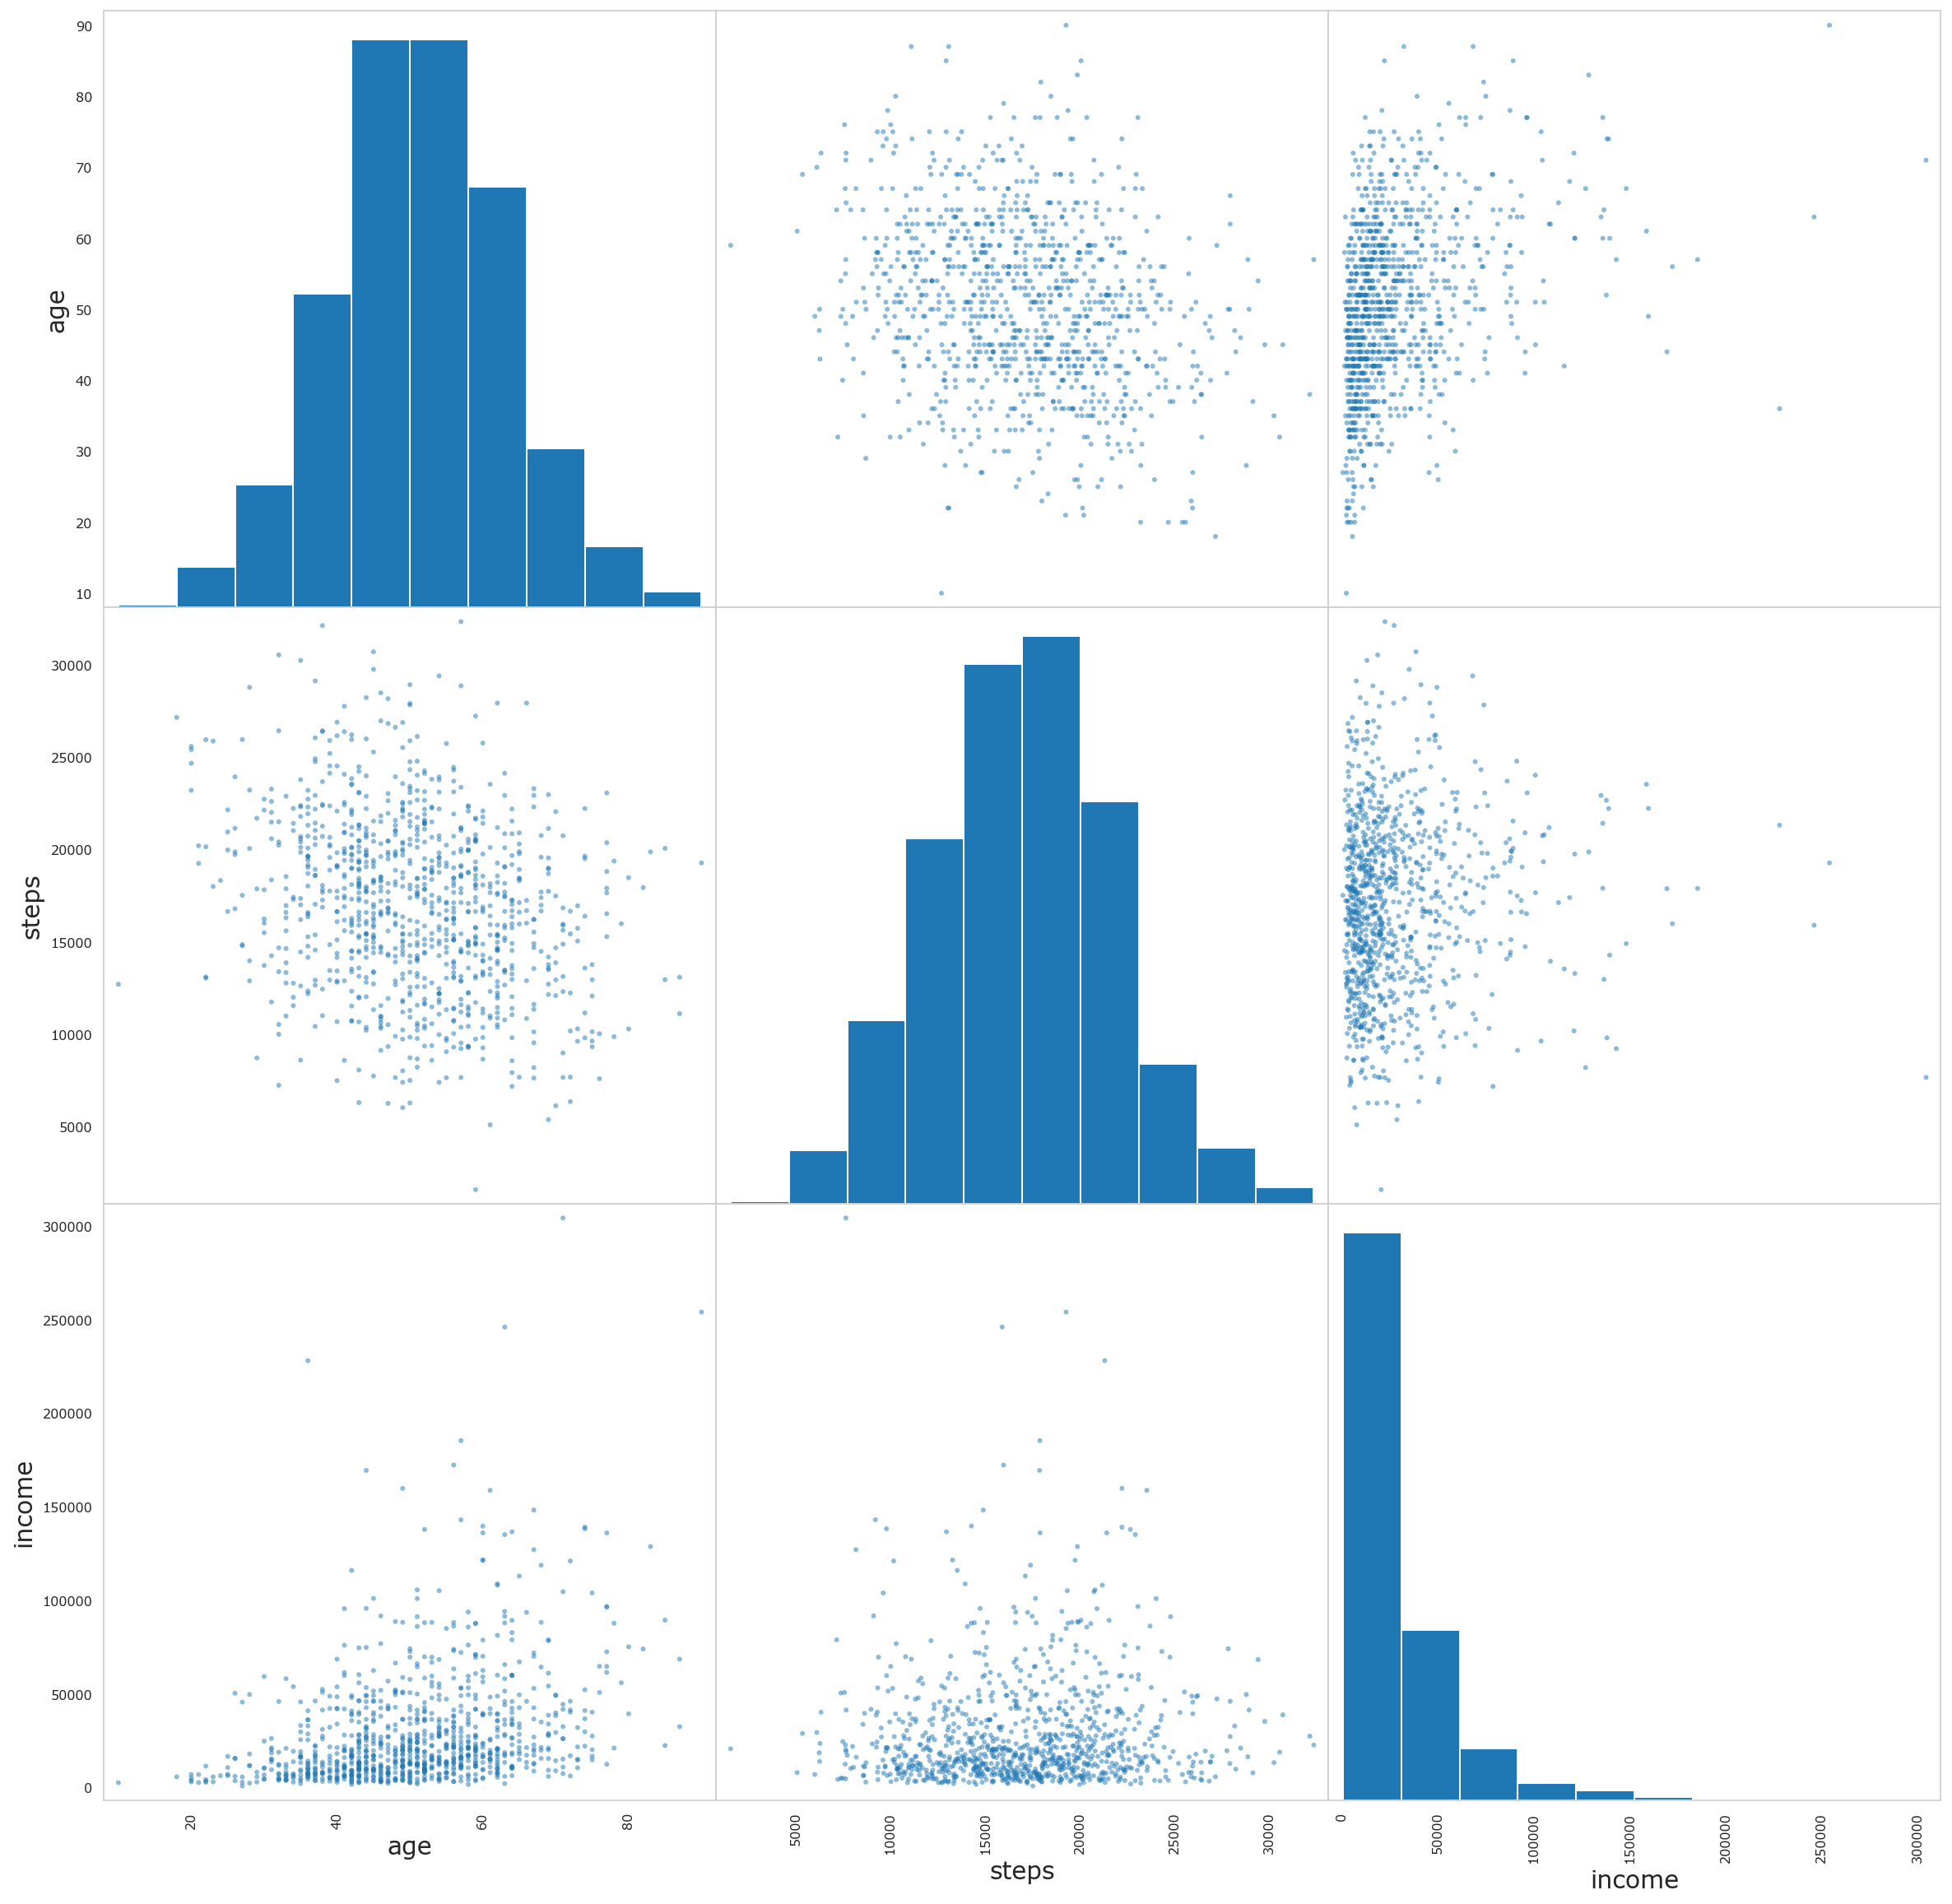

In [4]:
# correlation matrices

scatter_matrix(df[['age', 'steps', 'income']])
plt.show()


## Okay now that everything's working, let's mess it up a bit, add some nulls and improbable data, and export to different formats

In [5]:
# import json with random names and incomes
jsonfile = 'data/name_income.json'
name_income = pd.read_json(jsonfile)

# combine these data with the generated data above
name_income['income'] = df.income
name_income['id'] = df.id
name_income['age'] = df.age
name_income['steps'] = df.steps

# add some non-data
randpos = np.random.choice(range(people), 12, replace=False)
name_income.loc[randpos, 'income'] = None
randpos = np.random.choice(range(people), 74, replace=False)
name_income.loc[randpos, 'income'] = 0

# combine and sort by last name
name_income = name_income[['id', 'first_name', 'last_name', 'income']]
name_income = name_income.sort_values(['last_name'])
name_income

,id,first_name,last_name,income
892,92951,Jason,Adams,11677.39
554,58524,Paula,Adams,8038.76
187,14011,Louise,Alexander,25971.37
555,83370,Brian,Alexander,13319.79
925,23038,Willie,Alexander,14882.99
...,...,...,...,...
778,43454,Margaret,Wright,0.00
487,75071,Dennis,Young,3689.55
224,73264,Albert,Young,12108.33
241,52952,Stephanie,Young,9042.62


In [6]:
# write new json file for income

out = name_income[['id', 'last_name', 'first_name', 'income']]
out = out.to_json(orient='records')[1:-1].replace('},{', '},\n{')
out = '[' + out + ']'
with open('data/name_income_id.json', 'w') as f:
    f.write(out)


In [7]:
# write uid, age, and steps to csv
out = df
randpos = np.random.choice(range(people), 33, replace=False)
out.loc[randpos, 'steps'] = -1
out = out[['id', 'age', 'steps']]

out.to_csv('data/age_steps.csv', index=False)


In [8]:
# import new data

jsonfile = 'data/name_income_id.json'
name_income = pd.read_json(jsonfile)
csvfile = 'data/age_steps.csv'
age_steps = pd.read_csv(csvfile)


In [9]:
name_income


,id,last_name,first_name,income
0,92951,Adams,Jason,11677.39
1,58524,Adams,Paula,8038.76
2,14011,Alexander,Louise,25971.37
3,83370,Alexander,Brian,13319.79
4,23038,Alexander,Willie,14882.99
...,...,...,...,...
995,43454,Wright,Margaret,0.00
996,75071,Young,Dennis,3689.55
997,73264,Young,Albert,12108.33
998,52952,Young,Stephanie,9042.62


In [10]:
age_steps

,id,age,steps
0,49,63,17696
1,121,40,17391
2,172,62,27937
3,250,41,27768
4,289,36,-1
...,...,...,...
995,99587,70,13868
996,99711,53,16530
997,99724,58,12258
998,99919,57,-1


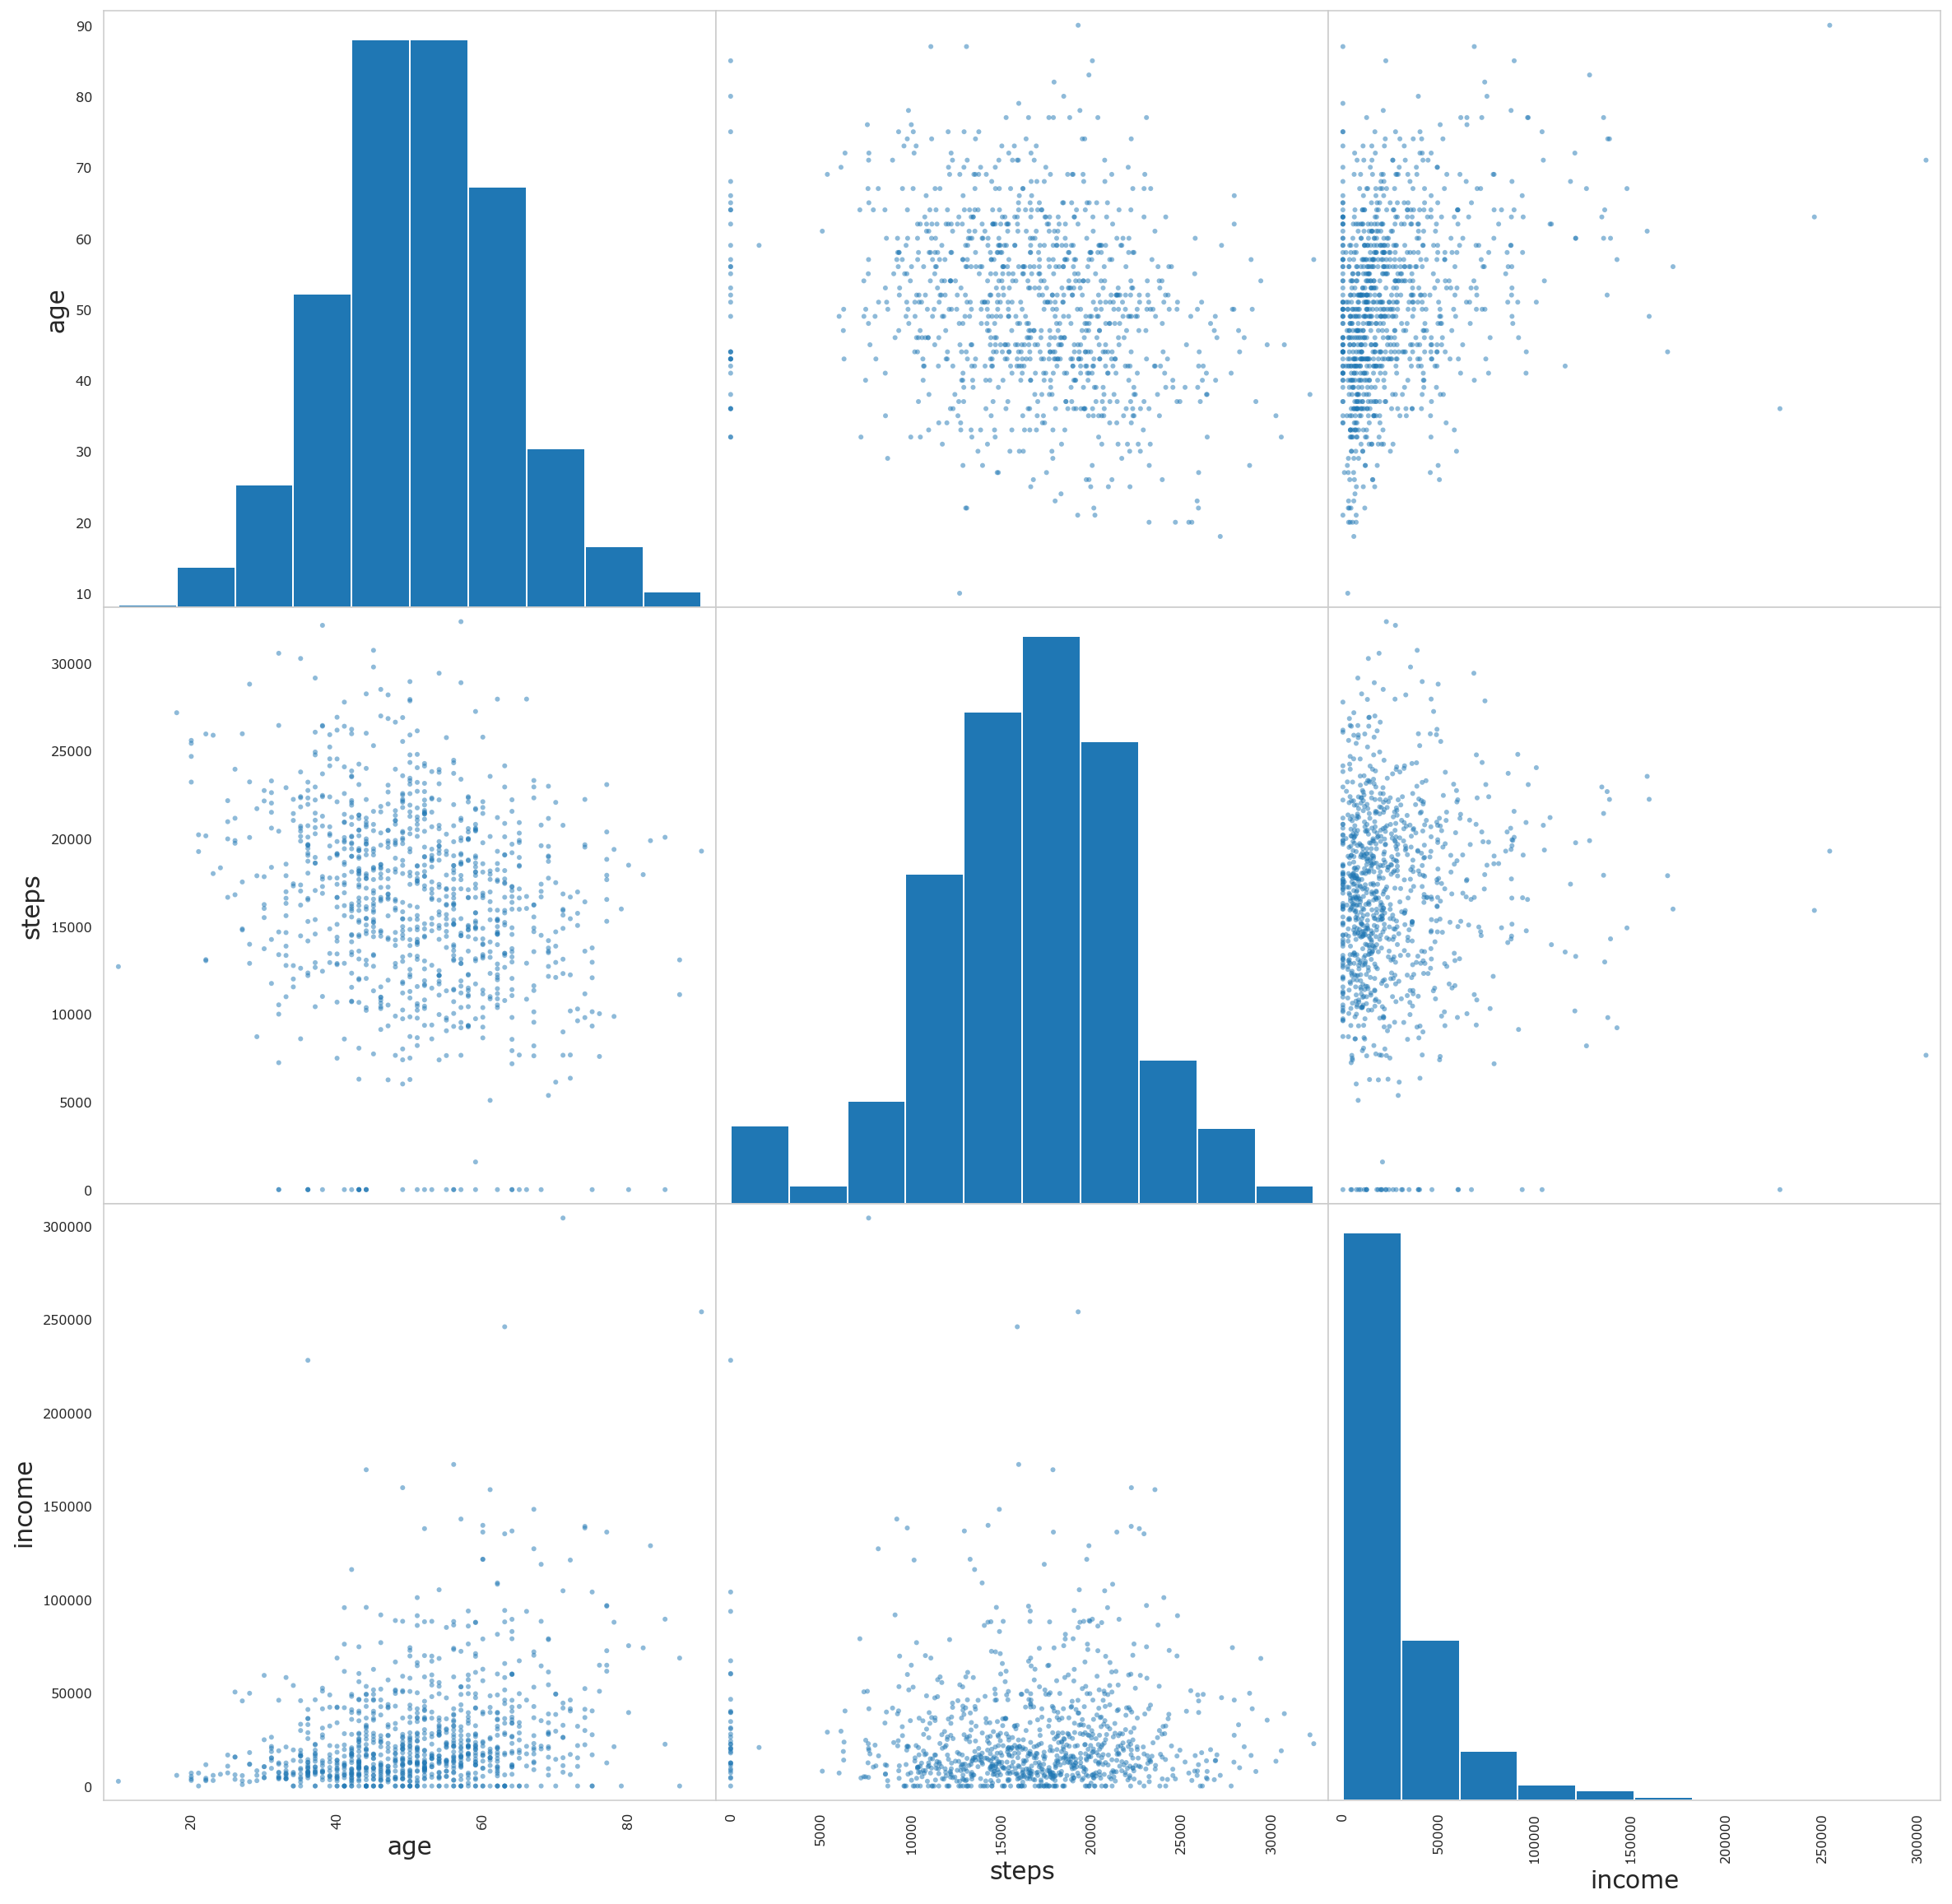

In [11]:
# join the two disparate datasets

df = pd.merge(name_income, age_steps, on='id')
df = df[['id', 'age', 'steps', 'income']]

# plot
scatter_matrix(df[['age', 'steps', 'income']])
plt.show()


## The below will throw an error! Why? Log-transforming the income fails, because some incomes are less than or equal to zero!

/Users/voytek/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Axis limits cannot be NaN or Inf

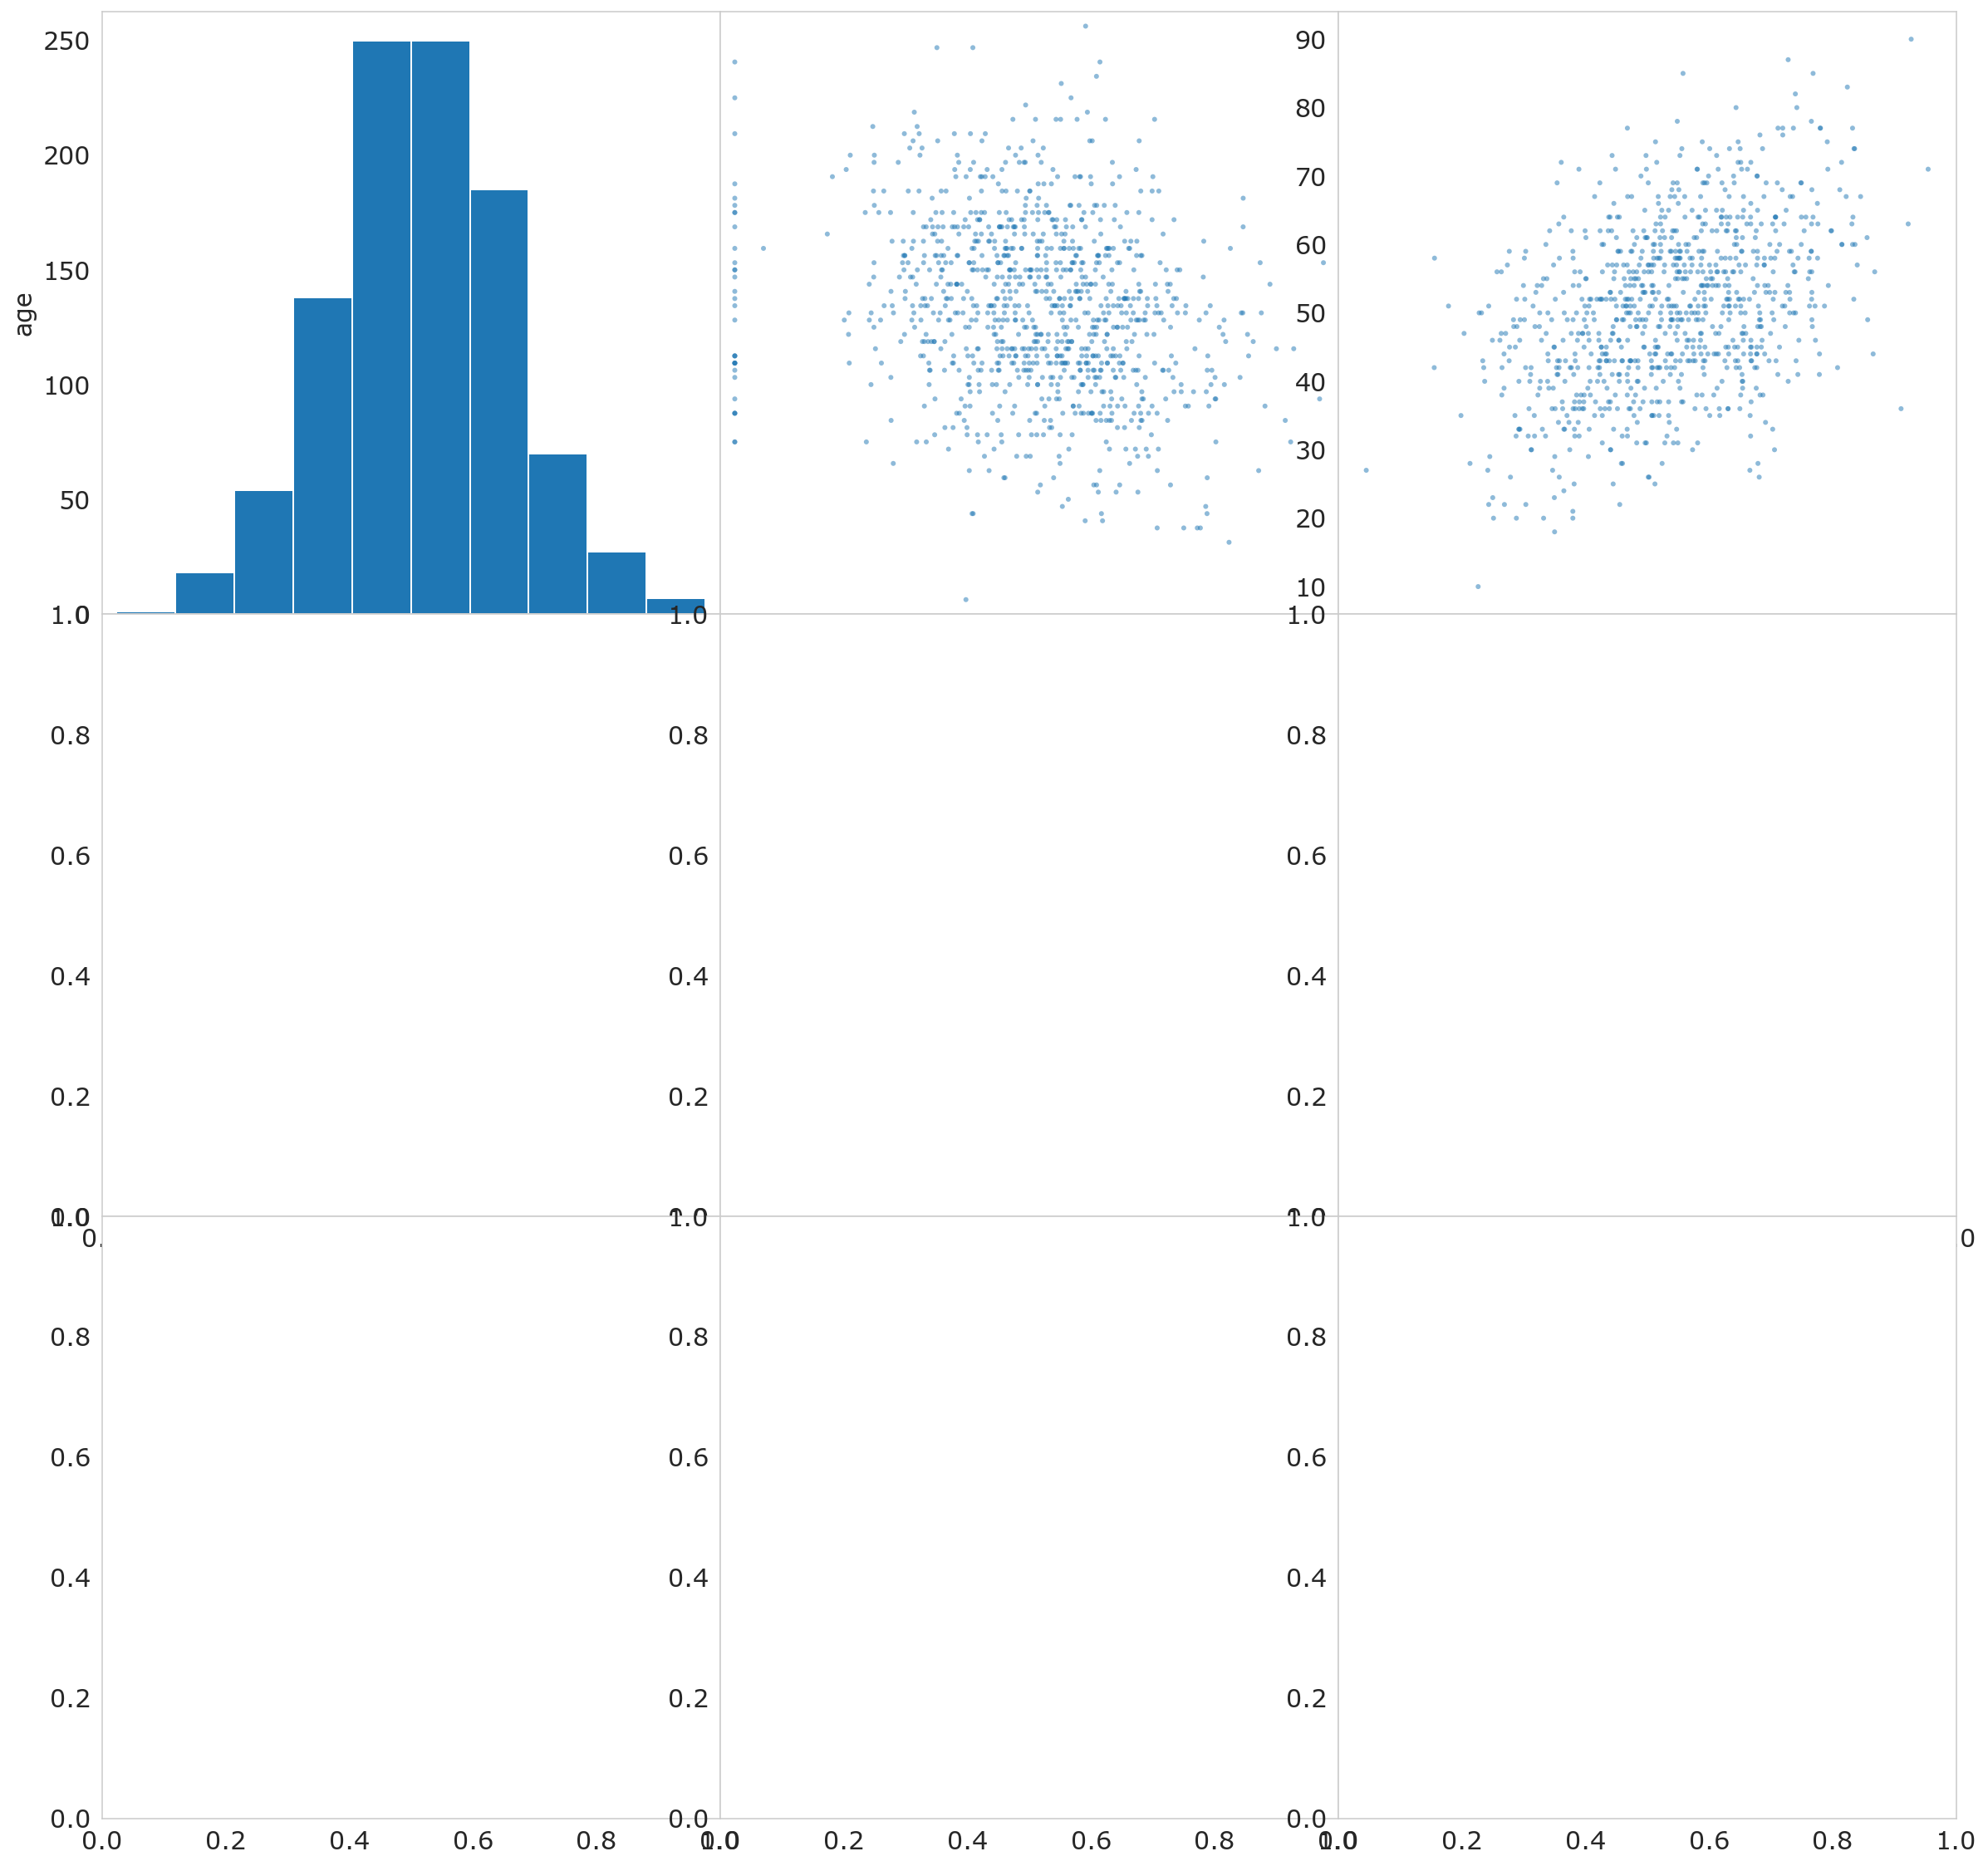

In [12]:
# log transform
df['income'] = np.log10(df['income'])

# plot
scatter_matrix(df[['age', 'steps', 'income']])
plt.show()

## So we need to clean up our data a bit, and get rid of those data. Here we do this by arbitarily setting income for those with <= \\$0 per year equal to \\$100

## But this assumes that people can't have less than zero income which... well sadly doesn't match reality, so how _else_ might you be able to address this in your analyses?

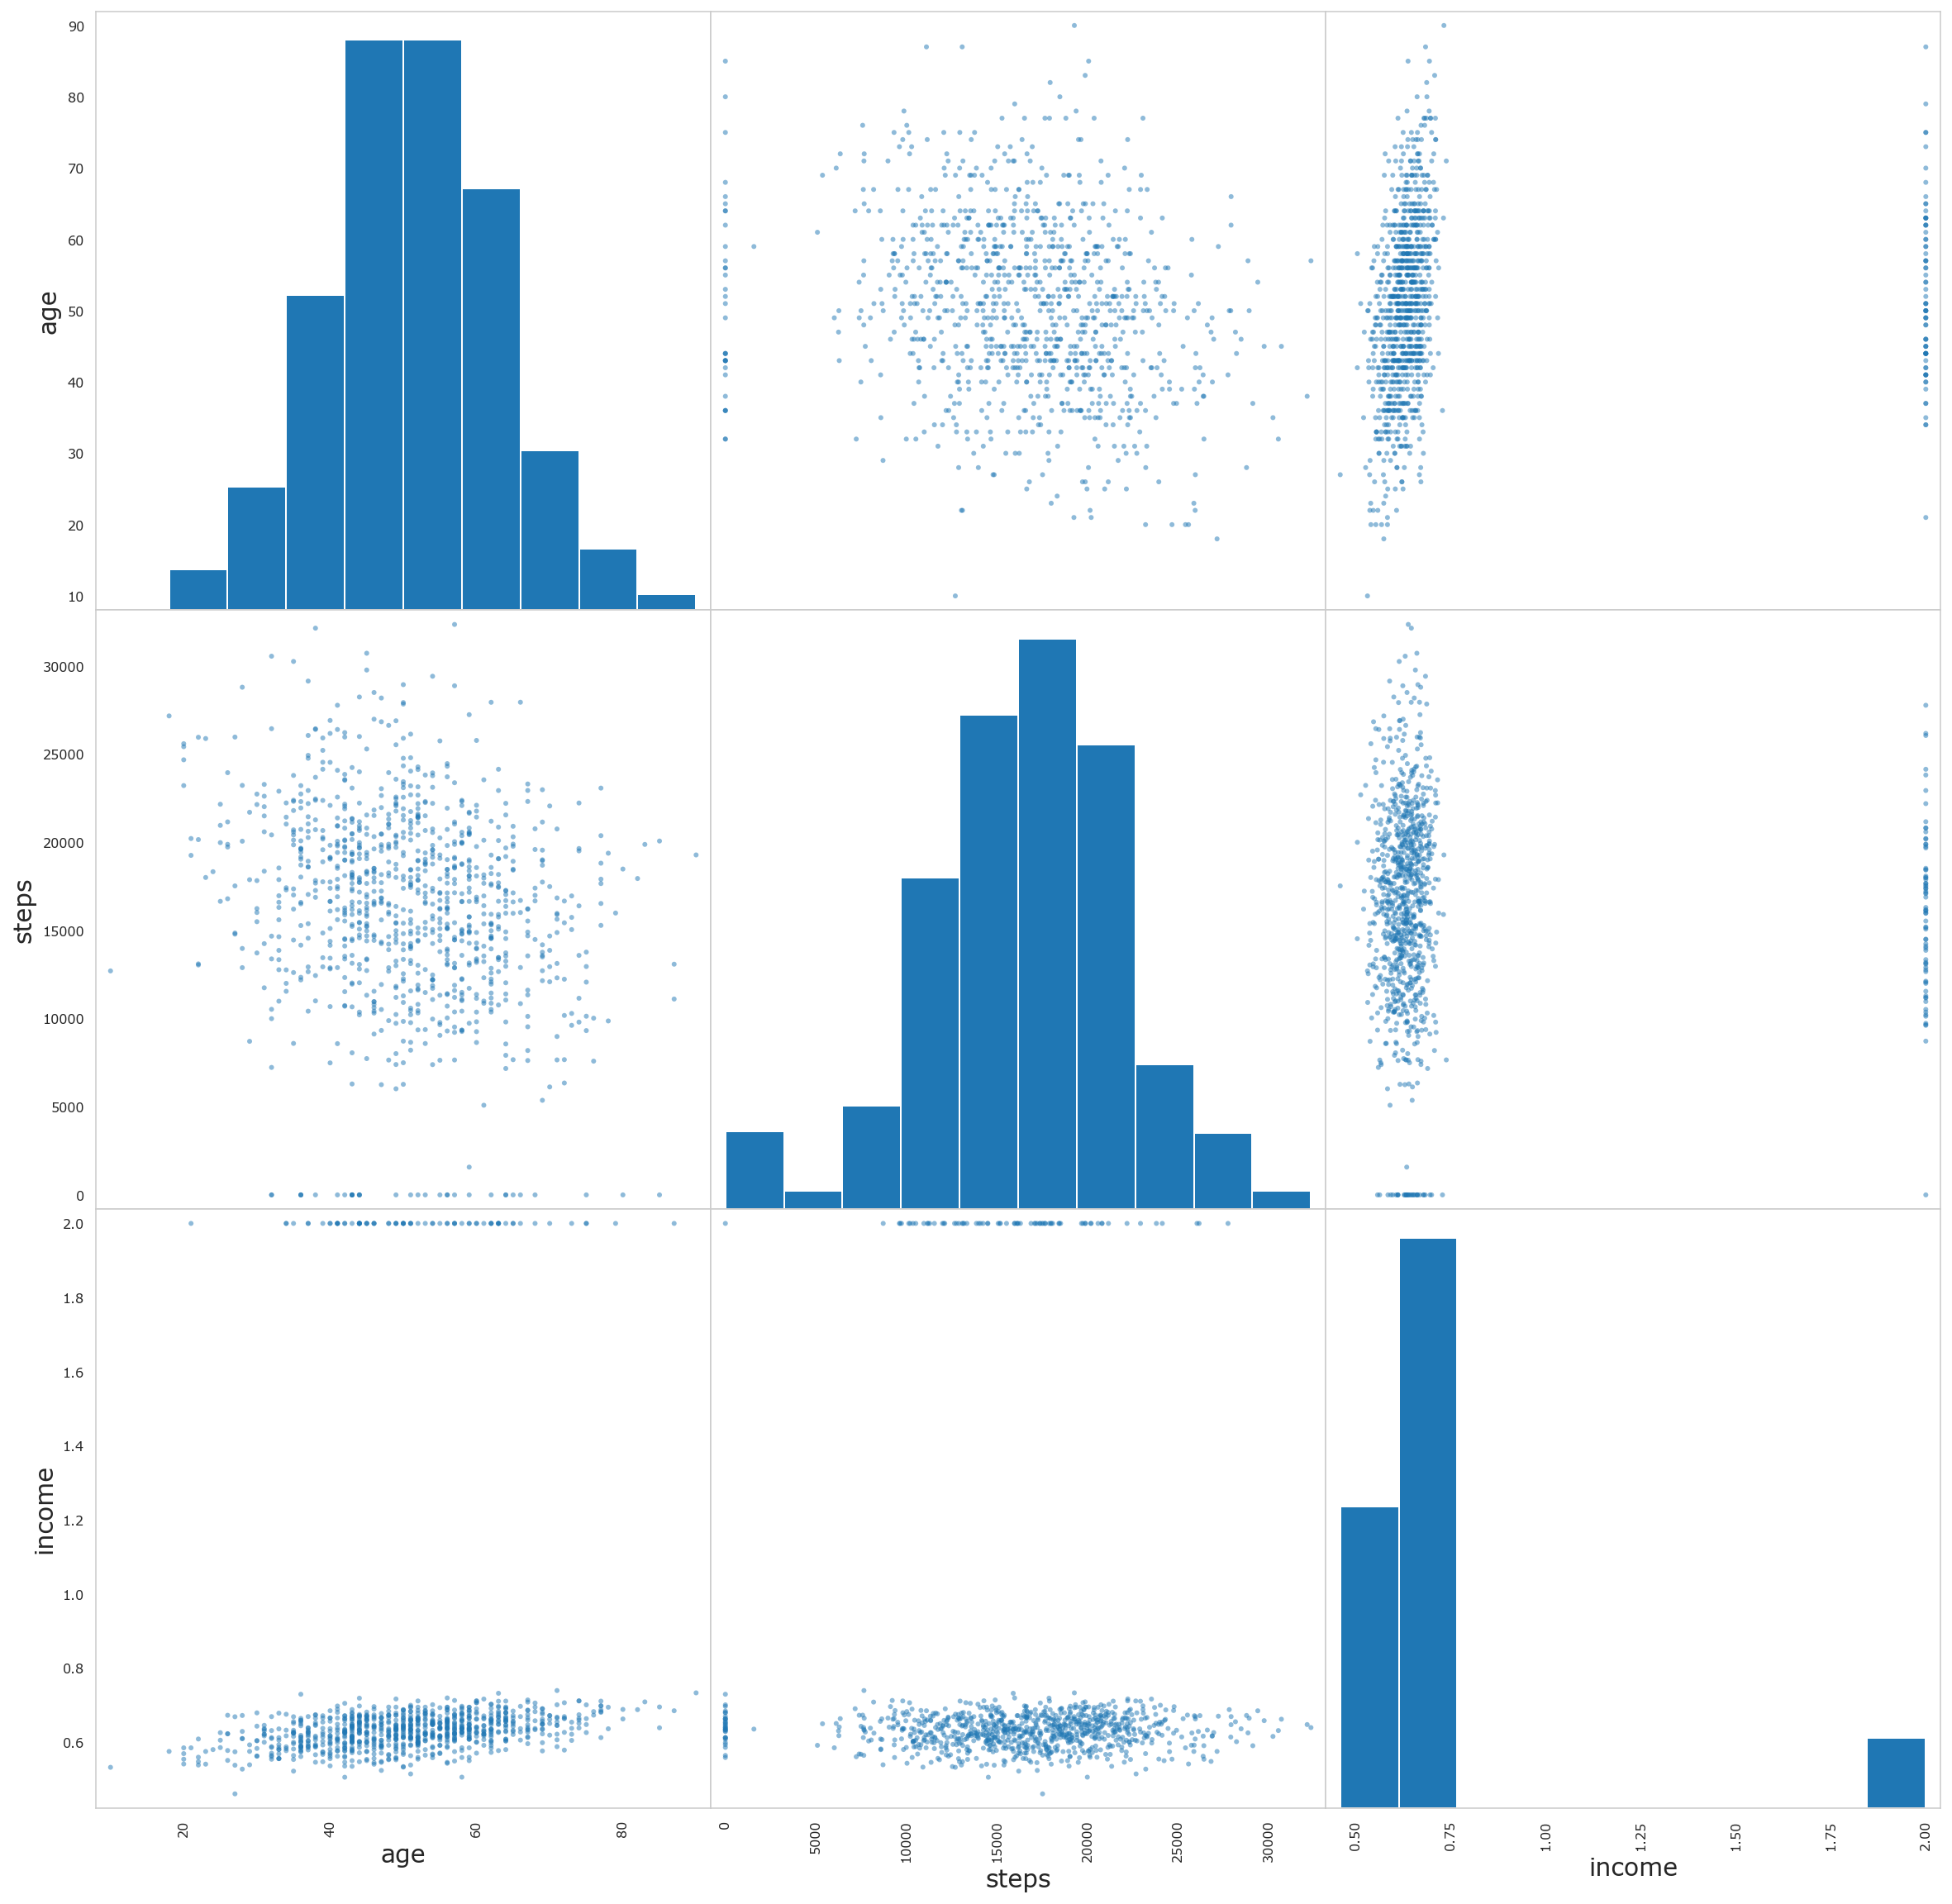

In [13]:
# cut outliers and bad data

replacement_income = 100

df.loc[df['income']<=0, 'income'] = replacement_income
df['income'] = np.log10(df['income'])

# plot
scatter_matrix(df[['age', 'steps', 'income']])
plt.show()

## We also have some folks with -1 steps, which we should also remove from our analyses before running our regression

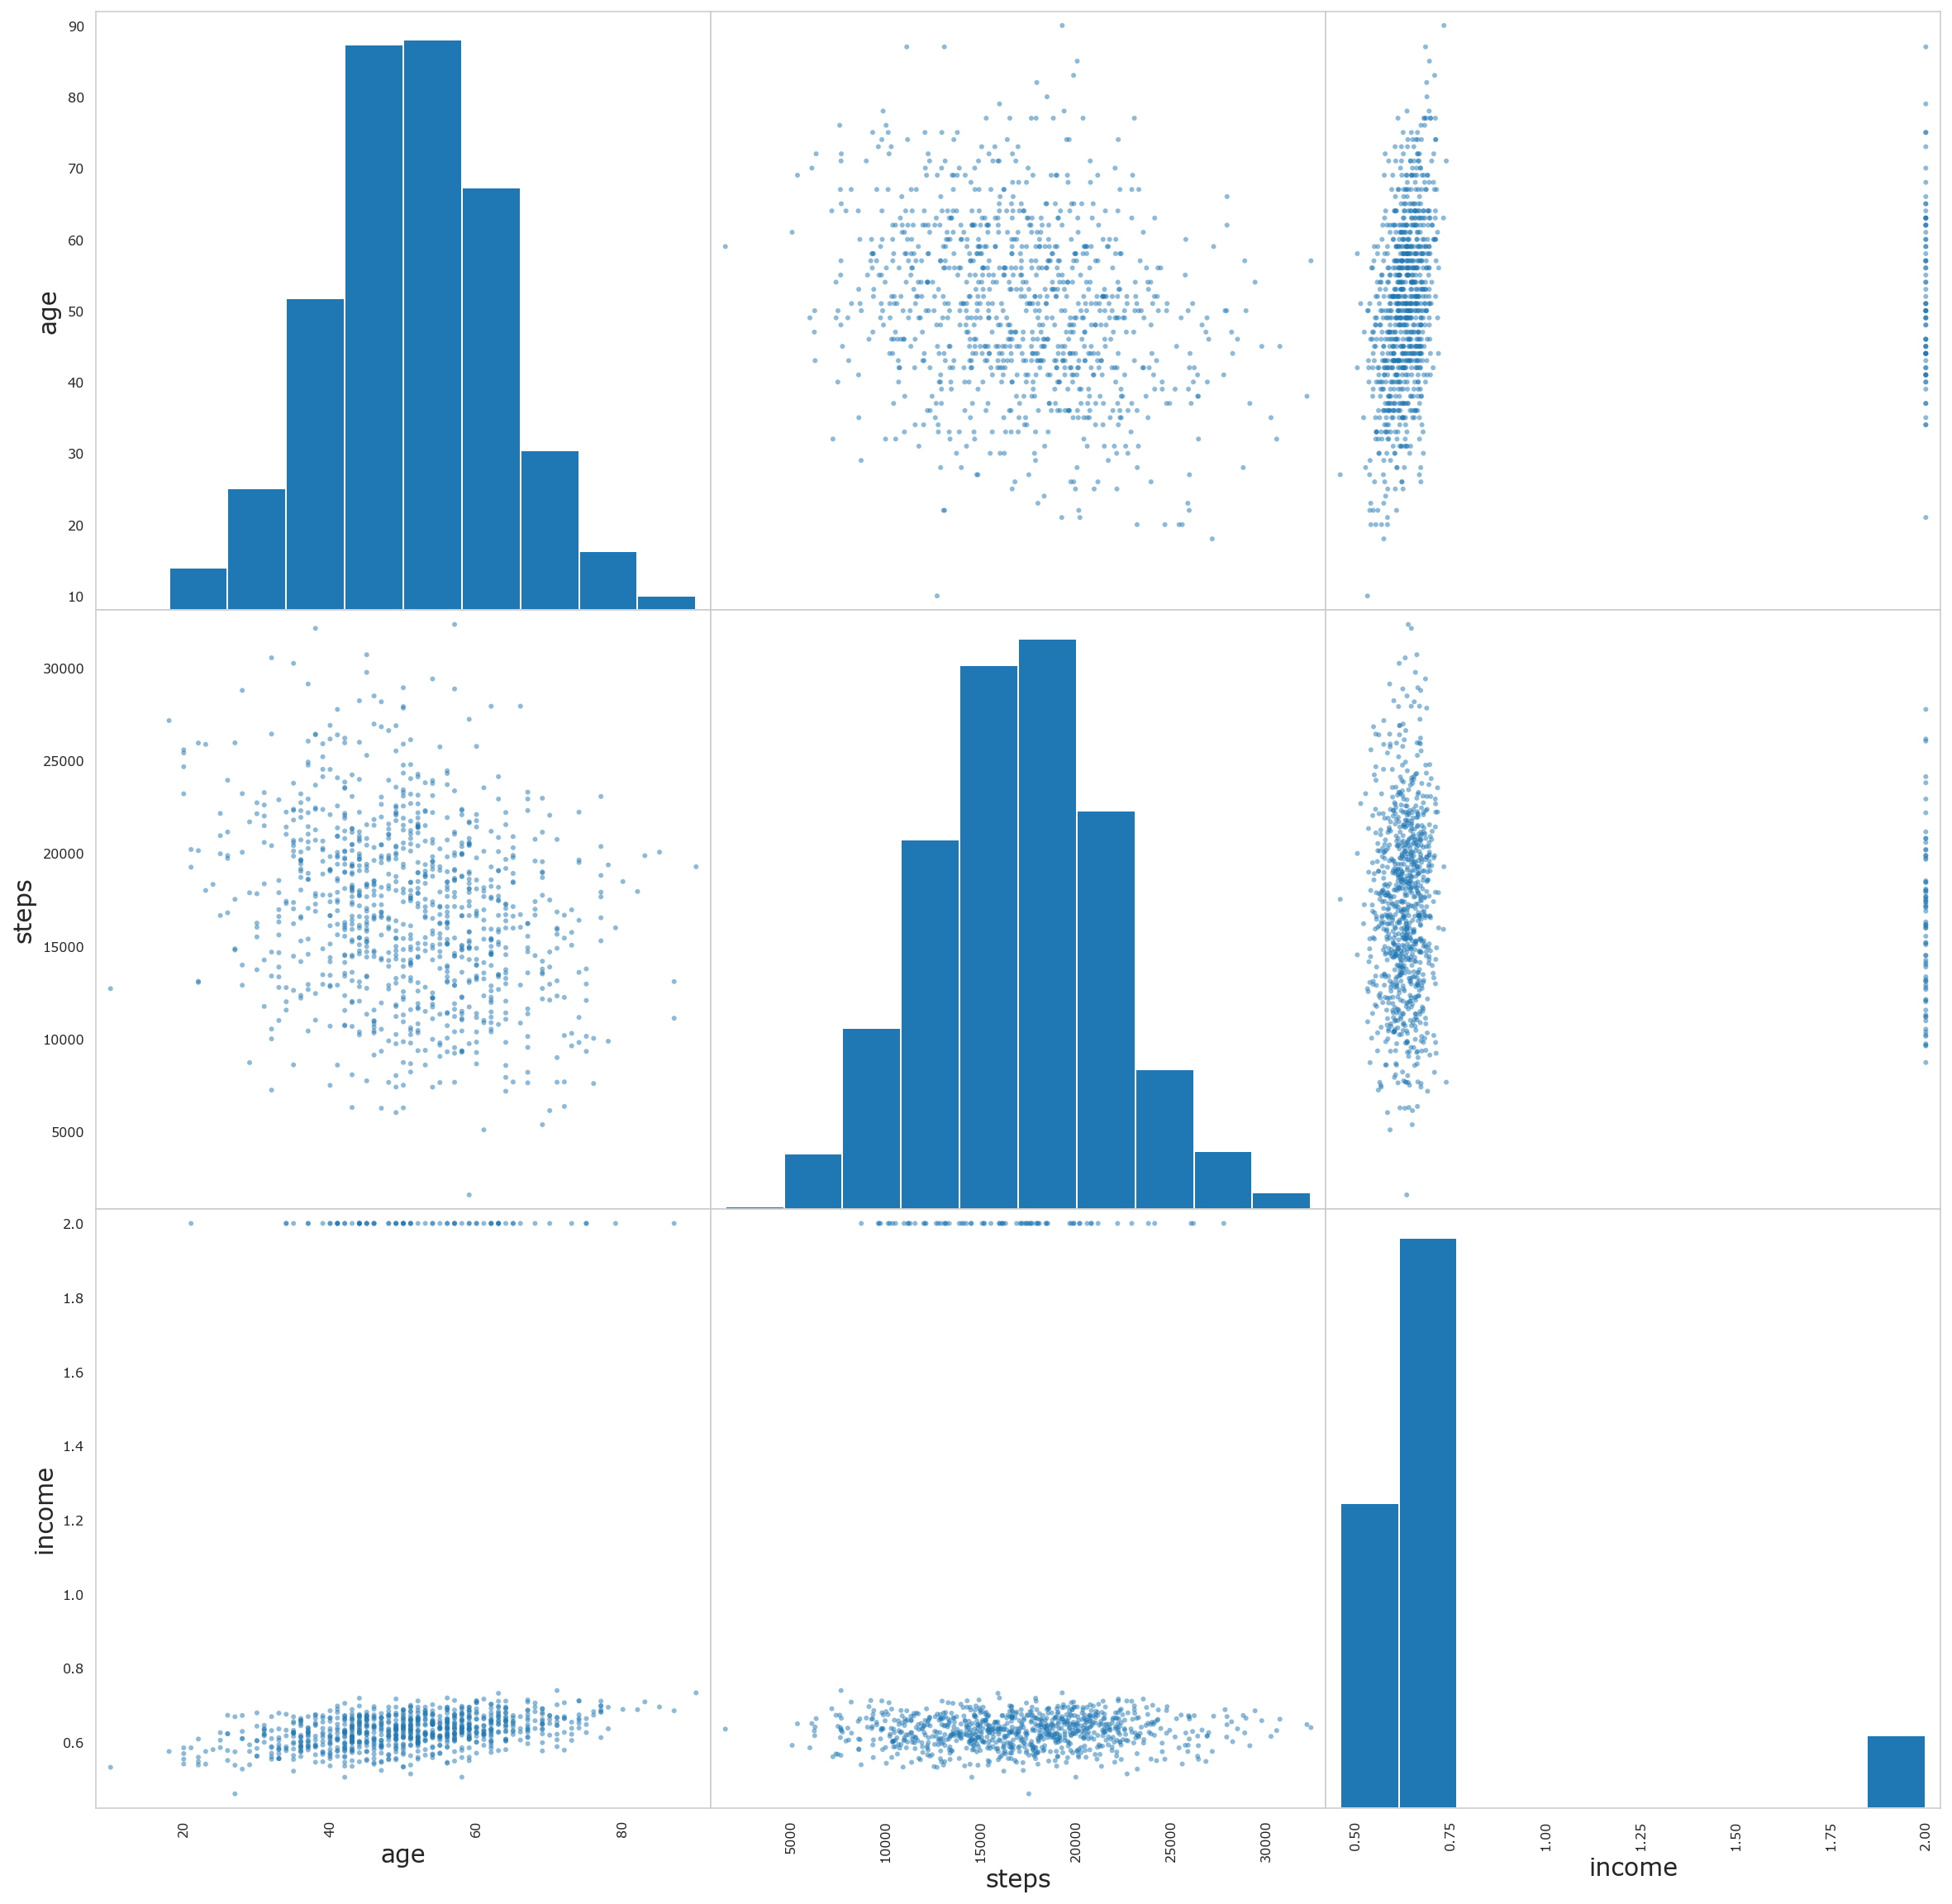

In [14]:
df = df[df.steps != -1]
scatter_matrix(df[['age', 'steps', 'income']])
plt.show()

In [15]:
np.shape(df)

(967, 4)

## We can also remove from our analyses anyone under the age of 18.

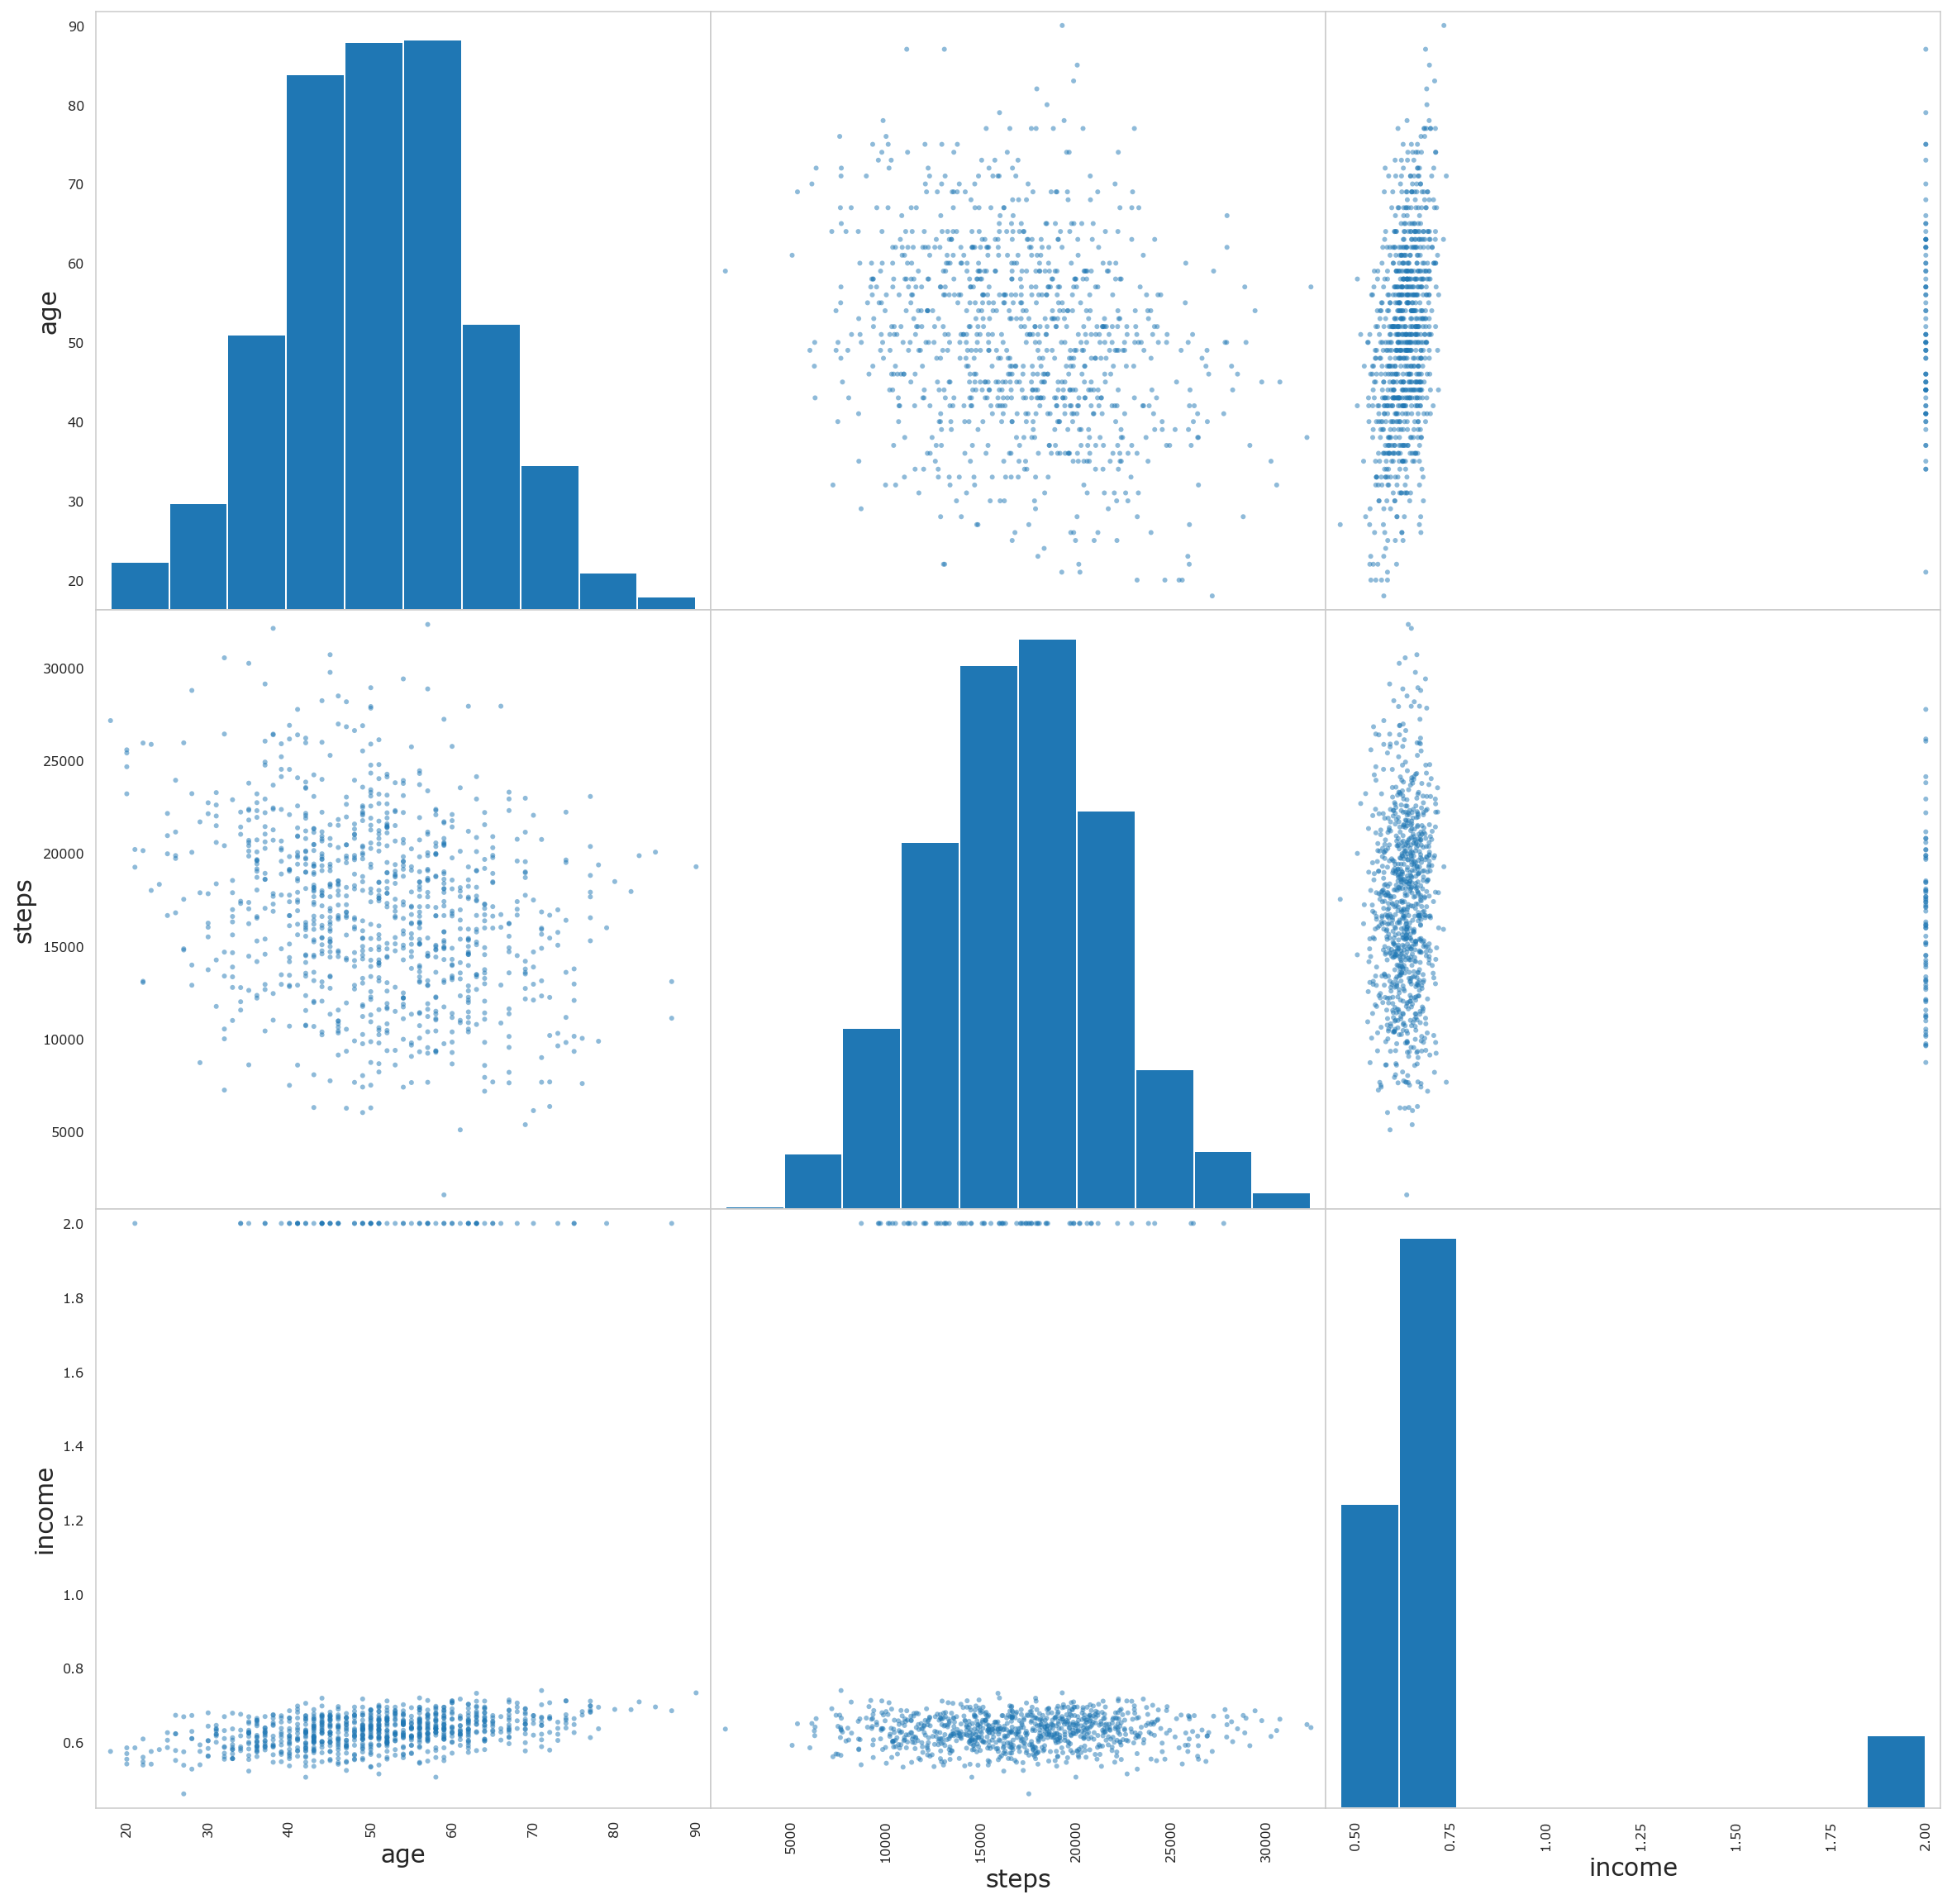

In [16]:
df = df[df.age >= 18]
scatter_matrix(df[['age', 'steps', 'income']])
plt.show()

In [17]:
np.min(df.age), np.shape(df)

(18, (966, 4))

In [18]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('income ~ age + steps', data=df, return_type='dataframe') # 

mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.717
Date:                Mon, 01 Feb 2021   Prob (F-statistic):             0.0247
Time:                        23:46:46   Log-Likelihood:                -392.50
No. Observations:                 956   AIC:                             791.0
Df Residuals:                     953   BIC:                             805.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6424      0.077      8.391      0.0

## Significant results! (By design, of course, since this is all fake data.)